<a href="https://colab.research.google.com/github/Rudi3601/CHC_Thesis/blob/main/Deep_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy import linalg

Importing Pandas

In [ ]:
import pandas as pd
import pandas_datareader.data as web
!pip install --upgrade pandas-datareader

In [ ]:
d=2
M=150

def nilpotent(M):
    B = np.zeros((M,M))
    for i in range(2,M):
        B[i,i-1]=1.0
    return B

def canonical(i,M):
    e = np.zeros((M,1))
    e[i,0]=1.0
    return e

def vectorfieldoperator(state,increment):
    d = np.shape(increment)[0]
    N = np.shape(state)[0]
    direction = np.zeros((N,1))
    for i in range(d):
        helper = np.zeros((N,1))
        for j in range(N):
            helper[j]=np.sin((j+1)*state[j,0])
        direction=direction + helper*increment[i]
    return direction

def vectorfield2d(state,increment):
    return np.array([(2.0*np.sqrt(state[1]**2))**0.7+np.sin(state[1]),1.0*state[1]+np.cos(state[1])])*increment[0]+np.array([(2.0*np.sqrt(state[1]**2))**0.7,0.0*state[1]])*increment[1]

def vectorfieldSABR(state,increment):
    return np.array([(np.sqrt(state[0]**2))**0.7*np.exp(-0.5*state[1]),0.1])*increment[0]+np.array([0,0.25*(state[0]+state[1])])*increment[1]

def vectorfieldinv(state,increment):
    return np.array([state[1]+state[0],state[1]-state[0]])*increment[0] + np.array([state[1],-state[0]])*increment[1]

def vectorfield3d(state,increment):
    return np.array([np.sin(5*state[0])*np.exp(-state[2]),np.cos(5*state[1]),-state[2]*state[1]])*increment[0]+np.array([np.sin(4*state[1]),np.cos(4*state[0]),-state[0]*state[1]])*increment[1]
def vectorfield(state,increment):
    return 5*np.exp(-state)*increment[0] + 5*np.cos(state)*increment[1]
def randomAbeta(d,M):
    A = []
    beta = []
    for i in range(d):
        B = 0.0*nilpotent(M) + np.random.normal(0.0,0.03,size=(M,M))
        B = np.random.permutation(B)
        A = A + [B]
        beta = beta + [0.0*canonical(i,M)+np.random.normal(0.0,0.03,size=(M,1))]
    return [A,beta]

Abeta = randomAbeta(d,M)
A = Abeta[0]
beta = Abeta[1]

def sigmoid(x):
    return np.tanh(x)

def reservoirfield(state,increment):
    value = np.zeros((M,1))
    for i in range(d):
        value = value + sigmoid(np.matmul(A[i],state) + beta[i])*increment[i]
    return value

SDE Class

In [ ]:
class SDE:
    def __init__(self,timehorizon,initialvalue,dimension,dimensionBM,dimensionR,vectorfield,timesteps):
        self.timehorizon = timehorizon
        self.initialvalue = initialvalue # np array
        self.dimension = dimension
        self.dimensionBM = dimensionBM
        self.dimensionR = dimensionR
        self.vectorfield = vectorfield
        self.timesteps = timesteps

    def path(self):
        BMpath = [np.zeros(self.dimensionBM)]
        SDEpath = [np.array([1.0, self.initialvalue])]
        for i in range(self.timesteps):
            helper = np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-1.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))]

        return [BMpath, SDEpath]

    def anypath(self):
        BMpath = [np.zeros(self.dimensionBM)]
        SDEpath = [np.array([1.0, self.initialvalue])]#[np.ones((self.dimension,1))*self.initialvalue]

        for i in range(self.timesteps):
            helper = np.cos(BMpath[-1]*50)*self.timehorizon/self.timesteps#np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-0.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))]

        return [BMpath, SDEpath]

    def reservoir(self,BMpath,scaling,k):
        reservoirpath = [canonical(k,self.dimensionR)*self.initialvalue]
        for i in range(self.timesteps):
            increment = scaling*(BMpath[i+1]-BMpath[i])
            reservoirpath = reservoirpath + [np.exp(-1.0*self.timehorizon/self.timesteps)*(reservoirpath[-1]+reservoirfield(reservoirpath[-1],increment))]
        return reservoirpath

In [ ]:
Sabr = SDE(1,1.0,2,d,M,vectorfieldSABR,10000)
training = Sabr.path()

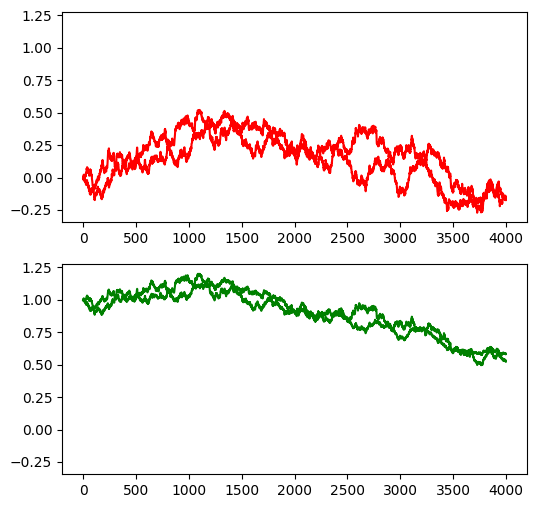

In [ ]:
f1,p1=plt.subplots(2,1,figsize=(6,6),sharey=True)
p1[0].plot(training[0][:4000],'r')
p1[1].plot(training[1][:4000],'g')
#plt.savefig('trainingpath.pdf')
plt.show()

In [ ]:
BMpath=training[0]
Y = training[1]
Ydata = np.squeeze(Y)
Ydatadiff = np.diff(Ydata,axis=0)
Ytrain = np.concatenate((Ydata[:2000],Ydatadiff[:2000:1]),axis=0)
np.shape(Ytrain)

(4000, 2)

In [ ]:
X=Sabr.reservoir(BMpath,1,0)
np.shape(X)
Xdata = np.squeeze(X)
for l in range(1):
    Xscaled=Sabr.reservoir(BMpath,0.5-l*0.1,0)
    Xscaleddata=np.squeeze(Xscaled)
    Xdata=np.concatenate((Xdata,Xscaleddata),axis=1)
#Xdata = np.concatenate((Xdata,Xdata**2),axis=1)
#Xdata = np.concatenate((Xdata,np.arctan(Xdata)),axis=1)#,np.arctan(4*Xdata)),axis=1)
Xdatadiff = np.diff(Xdata,axis=0)
Xtrain=np.concatenate((Xdata[:2000],Xdatadiff[:2000:1]),axis=0)
np.shape(Xtrain)

(4000, 300)

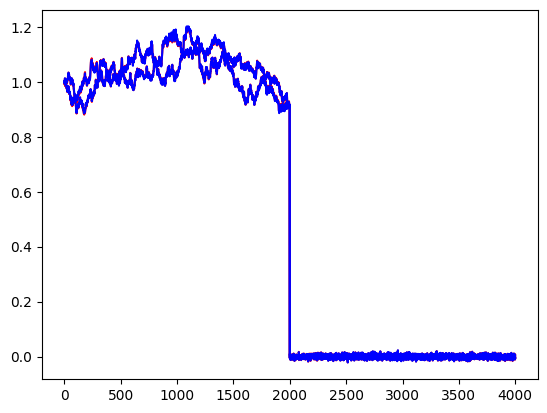

array([[ 4.97092183e-01, -6.11313318e-02,  1.34777661e-01,
        -2.45459990e-02,  1.00329695e-01, -1.85435290e-01,
         7.10483678e-02,  5.26329507e-02,  3.86697507e-02,
        -2.06336025e-02, -1.38819198e-02,  1.76408508e-02,
         7.52007878e-02, -1.09786383e-01, -1.31414593e-02,
         6.44828432e-02,  7.74172501e-02, -1.01952284e-01,
         1.11524507e-01, -2.02491745e-02, -5.02555221e-02,
        -1.64361813e-01,  3.28698353e-02, -1.48682386e-01,
        -3.30445373e-02, -1.46097479e-01, -4.69081578e-02,
        -4.13645222e-02,  3.94788794e-02, -4.82956822e-02,
         6.13510622e-02,  1.00160787e-02,  1.45501044e-01,
         1.37922346e-01, -5.04524730e-02, -3.76750403e-02,
         8.11482865e-02,  1.39120931e-02, -3.77757230e-02,
         1.83300902e-01,  5.03406787e-03,  3.31269632e-02,
        -1.18131036e-01,  1.31589639e-01,  7.44309509e-02,
         8.43578144e-02, -4.40131329e-02, -7.82777717e-02,
         4.46016605e-02, -3.85038024e-02, -8.17529764e-0

In [ ]:
from sklearn import linear_model
import pandas as pd
lm = linear_model.Ridge(alpha=0.05)#
model = lm.fit(Xtrain,Ytrain)
plt.plot(model.predict(Xtrain),'r')
plt.plot(Ytrain,'b')
plt.show()
model.score(Xtrain,Ytrain)
model.coef_

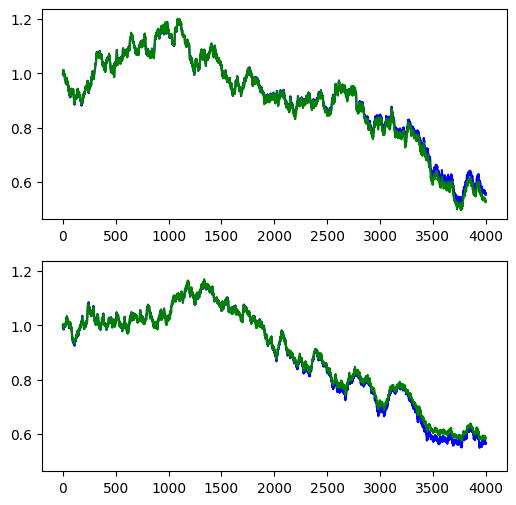

In [ ]:
f,p=plt.subplots(2,1,figsize=(6,6),sharey=True)

N=2

for i in range(N):
    p[i].plot(model.predict(Xdata[:4000])[:,i],'b')
    p[i].plot(Ydata[:4000][:,i],'g')
plt.savefig('training.pdf')
plt.show()

In [ ]:
generalization = Sabr.path()
BMpath = generalization[0]
Y = generalization[1]
Ydata = np.squeeze(Y)

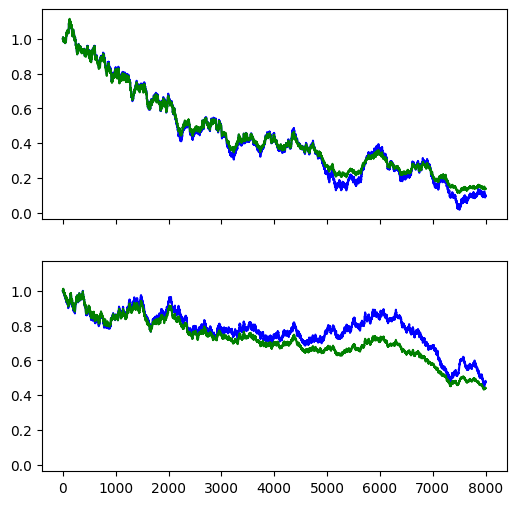

In [ ]:
X = Sabr.reservoir(BMpath,1,0)
Xdata = np.squeeze(X)
for l in range(1):
    Xscaled=Sabr.reservoir(BMpath,0.5-l*0.1,0)
    Xscaleddata=np.squeeze(Xscaled)
    Xdata=np.concatenate((Xdata,Xscaleddata),axis=1)
#Xdata = np.concatenate((Xdata,Xdata**2),axis=1)
#Xdata = np.concatenate((Xdata,np.arctan(Xdata)),axis=1)#np.arctan(4*Xdata)),axis=1)
N=2

fig,p=plt.subplots(N, 1, figsize=(6,6),sharex=True, sharey=True)
for i in range(N):
    p[i].plot(model.predict(Xdata[:8000])[:,i],'b')
    p[i].plot(Ydata[:8000][:,i],'g')
#plt.savefig('generalization.pdf')
plt.show()

In [ ]:
end = '2019-01-01'
start = '2014-01-01'
get_px = lambda x: web.get_data_yahoo(x, start=start, end=end)['Adj Close']

import yfinance as yfin
yfin.pdr_override()

symbols = ['MSFT','GOOG', 'BAC','AMZN','AAPL','INTC','PBR','JPM']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()
# linear returns
#lrets=(data-data.shift(1)).dropna()

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
data
#lrets.loc['2014-01-07'].values

,MSFT,GOOG,BAC,AMZN,AAPL,INTC,PBR,JPM
Date,,,,,,,,
2014-01-02,31.290829,27.724083,13.307186,19.898500,17.296658,19.378847,4.991772,44.047363
2014-01-03,31.080315,27.521841,13.563409,19.822001,16.916727,19.371336,4.916821,44.387878
2014-01-06,30.423512,27.828691,13.770040,19.681499,17.008968,19.130884,4.931810,44.645157
2014-01-07,30.659267,28.365179,13.637798,19.901501,16.887329,19.228567,4.834374,44.130604
2014-01-08,30.111950,28.424210,13.703921,20.096001,16.994272,19.108345,4.751927,44.546803
...,...,...,...,...,...,...,...,...
2018-12-24,89.385582,48.811001,20.125298,67.197998,35.187359,37.905788,4.723071,78.688416
2018-12-26,95.491486,51.973000,21.347166,73.544998,37.665302,40.166759,4.965079,81.950745
2018-12-27,96.080254,52.194000,21.577370,73.082001,37.420868,40.314590,4.996305,82.873077


In [ ]:
Omega = (lrets
         .rolling(30)
         .cov()
         .dropna())

In [ ]:
dates = lrets.index

In [ ]:
dates = dates[30:]

In [ ]:
covdata = dict(zip(dates, [Omega.loc[date].values for date in dates]))

In [ ]:
marketBM = dict(zip(dates, [np.matmul(np.linalg.inv(linalg.sqrtm(Omega.loc[date].values)),lrets.loc[date].values) for date in dates]))
#marketBM = dict(zip(dates, [np.matmul(np.linalg.inv(np.eye(9)),lrets.loc[date].values) for date in dates]))


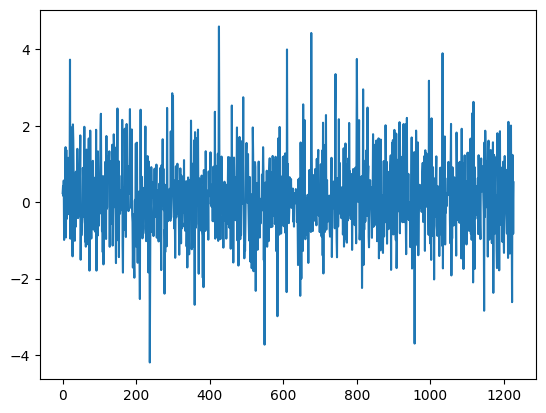

1.0073383852502118
0.09940000140802183


In [ ]:
plt.plot([marketBM[date][0] for date in dates])
plt.show()
print(np.std(np.array([marketBM[date][0] for date in dates])))
print(np.mean(np.array([marketBM[date][0] for date in dates])))

In [ ]:
K=8
BMmarketpath = 1/250*np.ones((len(dates),K))
mean=np.zeros(K)
for k in range(K):
    mean[k] = np.mean([marketBM[l][k] for l in dates])

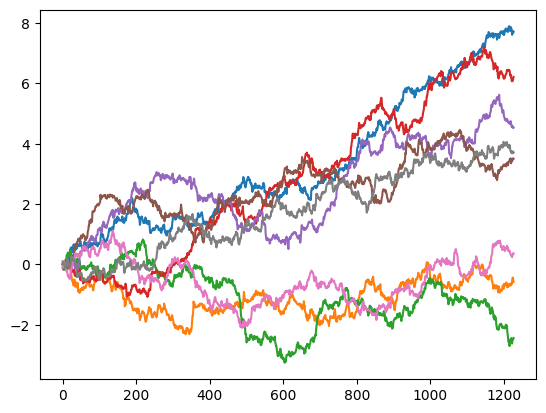

In [ ]:
for i in range(K):
    BMmarketpath[:,i] = np.cumsum([np.sqrt(1/250)*(marketBM[date][i]-0.*mean[i])
                                                   for date in dates])
#BMmarketpath[:,K]= np.cumsum(BMmarketpath[:,K])
plt.plot(BMmarketpath)
plt.show()

In [ ]:
Kmarket = 8
Ymarket = np.zeros((len(dates),Kmarket))
for i in range(Kmarket):
    Ymarket[:,i]=np.cumsum([lrets.loc[date].values[i] for date in dates])
Ymarket = np.exp(Ymarket)

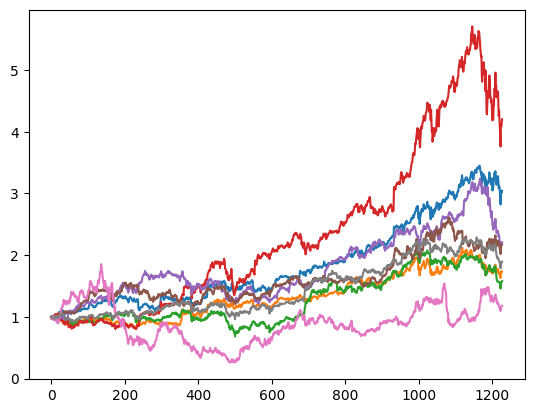

In [ ]:
plt.plot(Ymarket)
plt.show()

In [ ]:
Ymarketdiff = np.diff(Ymarket,axis=0)
Ymarkettrain = np.concatenate((Ymarket[:200],Ymarketdiff[:200:1]),axis=0)
np.shape(Ymarkettrain)

(400, 8)

In [ ]:
d=K
M=70

def nilpotent(M):
    B = np.zeros((M,M))
    for i in range(2,M):
        B[i,i-1]=1.0
    return B

def canonical(i,M):
    e = np.zeros((M,1))
    e[i,0]=1.0
    return e

def randomAbeta(d,M):
    A = []
    beta = []
    for i in range(d):
        #B = 0.1*np.identity(M)+np.random.normal(0.0,.5,size=(M,M))
        B = np.random.normal(0.0,0.02,size=(M,M)) # 0.1 for scen-gen, 1.5 for SABR
        #B = np.random.permutation(B)
        #B = np.identity(M)
        #B = sp.linalg.sqrtm(np.matmul(B,np.transpose(B)))
        A = A + [B]
        beta = beta + [0.*canonical(i,M)+np.random.normal(0.0,0.03,size=(M,1))]
    return [A,beta]

Abeta = randomAbeta(d,M)
A = Abeta[0]
beta = Abeta[1]

def sigmoid(x):
    return np.tanh(x)

def reservoirfield(state,increment):
    value = np.zeros((M,1))
    for i in range(d):
        value = value + sigmoid(np.matmul(A[i],state) + beta[i])*increment[i]
    return value

In [ ]:
BMmarketpathlist = [BMmarketpath[i,:] for i in range(len(dates))]
#BMmarketpathlist = [Ymarket[i,:K] for i in range(len(dates))]
Reservoir = SDE(1,1.5,2,K,M,vectorfield2d,len(dates)-1)
X=Reservoir.reservoir(BMmarketpathlist,0.5,0)
np.shape(X)
Xdata = np.squeeze(X)
Reservoir1 = SDE(1,0.0,2,K,M,vectorfield2d,len(dates)-1)
X1=Reservoir1.reservoir(BMmarketpathlist,0.4,0)
np.shape(X1)
Xdata1=np.squeeze(X1)
Reservoir2 = SDE(1,-1.5,2,K,M,vectorfield2d,len(dates)-1)
X2=Reservoir2.reservoir(BMmarketpathlist,0.3,0)
np.shape(X2)
Xdata2 = np.squeeze(X2)
Xdata = np.concatenate((Xdata,Xdata1,Xdata2),axis=1)
Xdatadiff = np.diff(Xdata,axis=0)
Xtrain=np.concatenate((Xdata[:200],Xdatadiff[:200:1]),axis=0)
np.shape(Xtrain)

(400, 210)

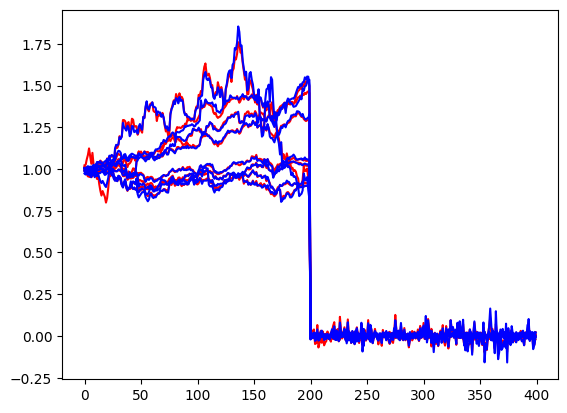

array([[ 0.32172586, -0.10155026,  0.10408367, ..., -0.02763772,
         0.02373883,  0.04535094],
       [ 0.30523526, -0.1025661 ,  0.00955695, ..., -0.03864076,
        -0.04103261, -0.00484784],
       [ 0.29784401, -0.06167979, -0.01399415, ...,  0.00107829,
        -0.01489078,  0.11280042],
       ...,
       [ 0.35301045, -0.21122836,  0.11662754, ..., -0.06692013,
        -0.01669065,  0.02121383],
       [ 0.3098362 ,  0.33008659,  0.38891595, ..., -0.209677  ,
         0.00408935,  0.10772584],
       [ 0.32544862, -0.08961467,  0.02714616, ...,  0.00299858,
         0.01967195,  0.08253105]])

In [ ]:
from sklearn import linear_model
import pandas as pd
lm = linear_model.Ridge(alpha=0.05)#LinearRegression()
model = lm.fit(Xtrain,Ymarkettrain)
plt.plot(model.predict(Xtrain),'r')
plt.plot(Ymarkettrain,'b')
plt.show()
model.score(Xtrain,Ymarkettrain)
model.coef_

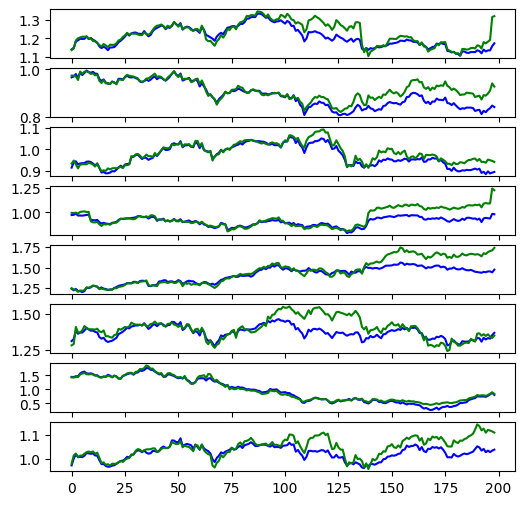

In [ ]:
f,p=plt.subplots(Kmarket,1,figsize=(6,6),sharey=False)

for i in range(Kmarket):
    p[i].plot(model.predict(Xdata[101:300])[:,i],'b')
    p[i].plot(Ymarket[101:300][:,i],'g')
plt.show()

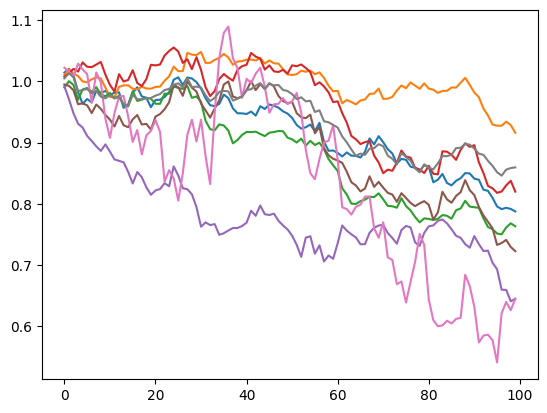

In [ ]:
BMmarketpathlistrandom = [np.zeros(K)]
for i in range(len(dates)):
    BMmarketpathlistrandom = BMmarketpathlistrandom + [BMmarketpathlistrandom[-1] + np.random.normal(0,1/np.sqrt(250),K)]
Reservoir = SDE(1,1.5,2,K,M,vectorfield2d,len(dates)-1)
Xtest=Reservoir.reservoir(BMmarketpathlistrandom,0.5,0)
np.shape(Xtest)
Xtestdata = np.squeeze(Xtest)
Reservoir1 = SDE(1,0.0,2,K,M,vectorfield2d,len(dates)-1)
Xtest1=Reservoir1.reservoir(BMmarketpathlistrandom,0.4,0)
np.shape(Xtest1)
Xtestdata1 = np.squeeze(Xtest1)
Reservoir2 = SDE(1,-1.5,2,K,M,vectorfield2d,len(dates)-1)
Xtest2=Reservoir2.reservoir(BMmarketpathlistrandom,0.3,0)
np.shape(Xtest2)
Xtestdata2 = np.squeeze(Xtest2)
Xtestdata = np.concatenate((Xtestdata,Xtestdata1,Xtestdata2),axis=1)

plt.plot(model.predict(Xtestdata[:100]))
plt.show()